In [1]:
import pathlib
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
results_dir = pathlib.Path("./results").resolve(strict=True)
map_results_dir = (results_dir / "map_scores").resolve(strict=True)

# Setting AP and mAP scores paths
nc_dmso_ap_path = (map_results_dir / "negative_control_failing_DMSO_AP_scores.csv").resolve(strict=True)
pc_dmso_ap_path = (map_results_dir / "positive_control_healthy_DMSO_AP_scores.csv").resolve(strict=True)
nc_dmso_map_path = (map_results_dir / "negative_control_failing_DMSO_mAP_scores.csv").resolve(strict=True)
pc_dmso_map_path = (map_results_dir / "positive_control_healthy_DMSO_mAP_scores.csv").resolve(strict=True)

# make directory for figures
fig_dir_path = (results_dir / "figures").resolve()
fig_dir_path.mkdir(exist_ok=True)

# pathway informaiton
pathway_info = pathlib.Path("../data/metadata/original_platemaps/pathways_platemap.csv").resolve(strict=True)

In [3]:
interested_cols = ["Metadata_treatment", "mean_average_precision", "corrected_p_value"]
pathway_df = pd.read_csv(pathway_info)[["UCD ID", "Pathway"]]
nc_map_df = pd.read_csv(nc_dmso_map_path)[interested_cols]
pc_map_df = pd.read_csv(pc_dmso_map_path)[interested_cols]

# rename columns 
nc_map_df = nc_map_df.rename(columns={"mean_average_precision":"negative_mean_average_precision", "corrected_p_value":"negative_corrected_p_value"})
pc_map_df = pc_map_df.rename(columns={"mean_average_precision":"positive_mean_average_precision", "corrected_p_value":"positive_corrected_p_value"})

# merge both together
all_map_df = nc_map_df.merge(pc_map_df, on="Metadata_treatment", how="inner")

# calculating delta mAP
all_map_df["delta_mAP"] = all_map_df["positive_mean_average_precision"] - all_map_df["negative_mean_average_precision"]

# now leta add pathway information into this data
all_map_df = all_map_df.merge(pathway_df, left_on="Metadata_treatment", right_on="UCD ID", how="inner")
all_map_df = all_map_df.drop(columns="UCD ID")
all_map_df.head()

,Metadata_treatment,negative_mean_average_precision,negative_corrected_p_value,positive_mean_average_precision,positive_corrected_p_value,delta_mAP,Pathway
0,UCD-0000450,0.855556,0.001194,1.000000,0.001748,0.144444,Neuronal Signaling
1,UCD-0001014,0.731250,0.001194,0.916667,0.003158,0.185417,Neuronal Signaling
2,UCD-0001016,1.000000,0.001194,1.000000,0.001748,0.000000,Neuronal Signaling
3,UCD-0001024,0.201064,0.020025,0.476527,0.036985,0.275463,Neuronal Signaling
4,UCD-0001040,0.979167,0.001194,1.000000,0.001748,0.020833,Endocrinology & Hormones


## Dual-Control mAP Analysis: Evaluating Therapeutic Potential Through Comparative Phenotypic Scoring

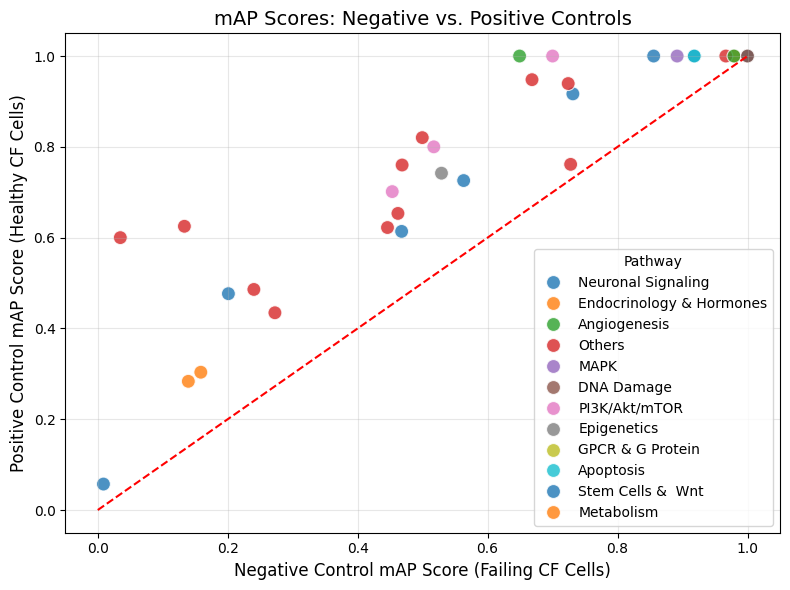

In [4]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=all_map_df, 
    x="negative_mean_average_precision", 
    y="positive_mean_average_precision", 
    hue="Pathway",
    palette="tab10", 
    s=100, 
    alpha=0.8
)

# Add a red diagonal line starting from (0,0)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5, label="Reference Line (Diagonal)")

# Add titles and labels
plt.title("mAP Scores: Negative vs. Positive Controls", fontsize=14)
plt.xlabel("Negative Control mAP Score (Failing CF Cells)", fontsize=12)
plt.ylabel("Positive Control mAP Score (Healthy CF Cells)", fontsize=12)
# plt.legend(loc="upper left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# save plot
plt.savefig(fig_dir_path / "map_scores_negative_vs_positive.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

## Differential mAP scores Histogram analysis (Pathway Level)

The primary goal of using differential mAP scores (dMAP)  in this high-content screening is to evaluate the therapeutic potential of 550 compounds for reversing cardiac fibrosis. By comparing the morphological profiles of treated diseased cells against two controls failing cardiac cells (negative control) and healthy cardiac cells (positive control) the differential mAP scores help identify compounds that effectively shift the diseased phenotype toward the healthy state. (this is a prototype)

$$
\begin{equation}
\Delta \text{mAP} = \text{mAP}_{\text{Positive Control}} - \text{mAP}_{\text{Negative Control}}
\end{equation}
$$

$\text{mAP}_{\text{Positive Control}}  ( Y )$:

- The mean average precision score when comparing treated diseased cells to the healthy control.
- A higher  $Y$ indicates that the compound shifts the diseased cells closer to the healthy phenotype.

$\text{mAP}_{\text{Negative Control}}  ( X )$:

- The mean average precision score when comparing treated diseased cells to the failing control.
- A higher $X$ indicates that the compound’s effect is similar to the diseased phenotype, with minimal therapeutic relevance.

$ \Delta \text{mAP}  ( Y - X ):$
- The difference between  $\text{mAP}{\text{Positive Control}}  and  \text{mAP}{\text{Negative Control}}$ .
- This score provides a measure of how effectively a compound reverses the failing phenotype.

What is the range of the score?

The range of these scores is [-1, 1]

- **Positive** $\Delta \text{mAP}$ $(0 < \Delta \text{mAP} \leq 1)$:  
  Indicates the compound aligns more with the healthy phenotype than the diseased phenotype.

- **Negative** $\Delta \text{mAP}$ $(-1 \leq \Delta \text{mAP} < 0)$:  
  Indicates the compound aligns more with the diseased phenotype than the healthy phenotype.

- **Zero** $\Delta \text{mAP}$ $(\Delta \text{mAP} = 0)$:  
  Indicates no difference between the compound's effect on healthy and diseased phenotypes.


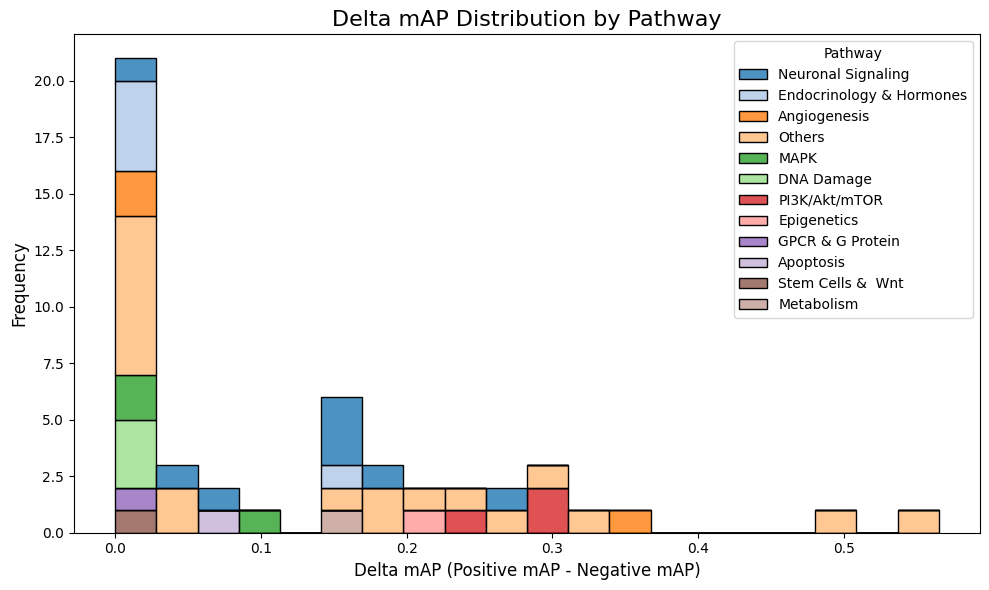

In [5]:
# Plot stacked bar histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    data=all_map_df, 
    x="delta_mAP", 
    hue="Pathway", 
    multiple="stack", 
    bins=20, 
    palette="tab20", 
    alpha=0.8
)

# Add plot labels and title
plt.title("Delta mAP Distribution by Pathway", fontsize=16)
plt.xlabel("Delta mAP (Positive mAP - Negative mAP)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()

# save plot
plt.savefig(fig_dir_path / "delta_mAP_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

Positive vs. Negative  $\Delta \text{mAP}$ :

- Bars on the **left side of the X-axis** (negative  $\Delta \text{mAP}$ ) represent compounds aligning more with the diseased phenotype.
- Bars on the **right side of the X-axis** (positive  $\Delta \text{mAP}$ ) represent compounds aligning more with the healthy phenotype.

Leveraging Delta mAP can also provide an opportunity to rank them from highest to lowest and identify potential hits. 

/tmp/ipykernel_1182820/3917116291.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_map_df["rank"] = delta_map_df["delta_mAP"].rank(ascending=True, method="min")


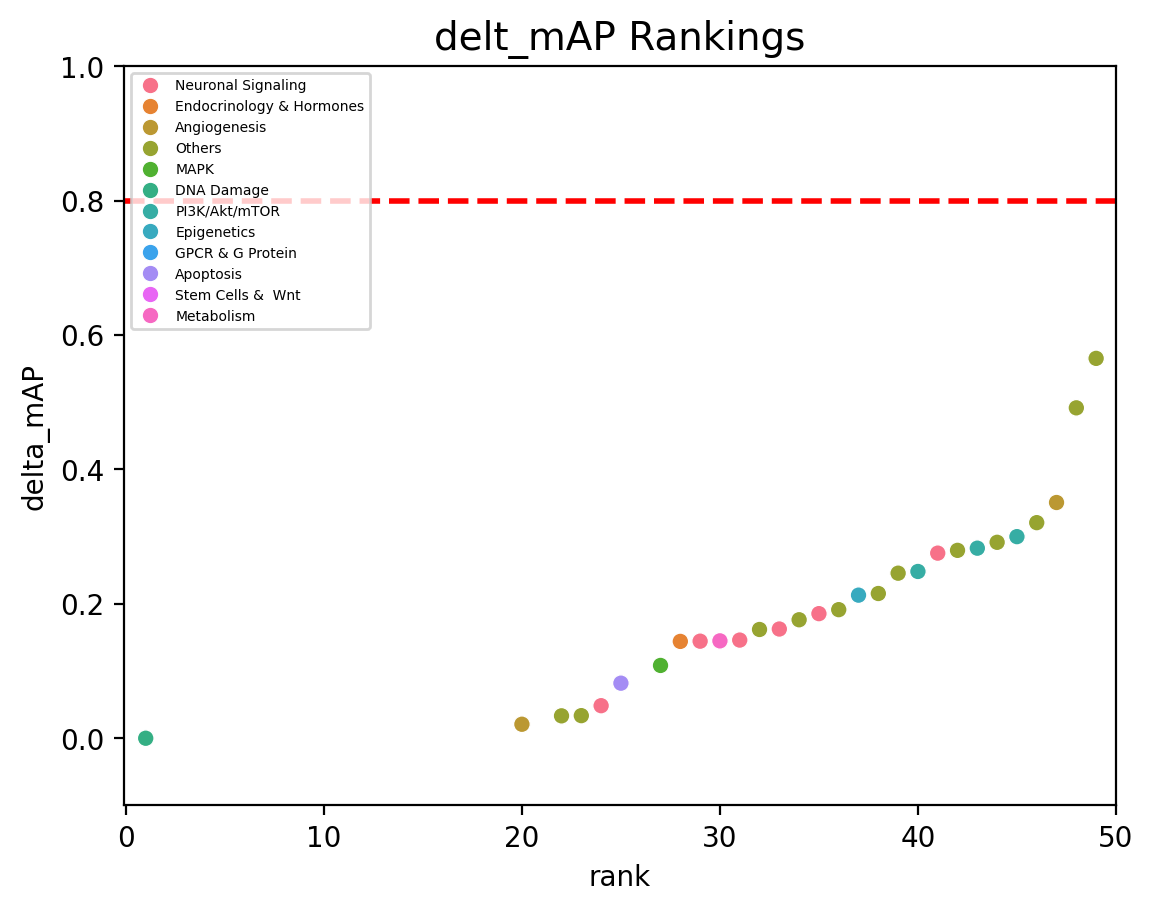

In [6]:
plt.figure(dpi=200)
# parameters 
threshold = 0.80 # this will change depending on additional experiments 

# only getting the delta map scores
delta_map_df = all_map_df[["Metadata_treatment", "delta_mAP", "Pathway"]]
# Add ranks to the DataFrame
delta_map_df["rank"] = delta_map_df["delta_mAP"].rank(ascending=True, method="min")

sns.scatterplot(data=delta_map_df,
                x="rank", 
                y="delta_mAP",
                hue="Pathway")


plt.title("delt_mAP Rankings", fontsize=14)
plt.xlim(-0.1, delta_map_df["rank"].max() + 1)
plt.ylim(-0.1, 1)
plt.rc("legend", fontsize=5)
plt.rc("legend", title_fontsize=10)
plt.legend( loc="upper left")
plt.axhline(y=0.80, color="red", linestyle="--", linewidth=2, label="Threshold: 0.80")

# save plot
plt.savefig(fig_dir_path / "delta_mAP_rankings.png", dpi=300, bbox_inches="tight")